### Importing Libraries

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

### Data preprocessing steps:

In [2]:
%%time
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')



# Merging Transaction and Identity data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 36.9 s, sys: 8.19 s, total: 45.1 s
Wall time: 50.5 s


In [3]:
del train_transaction
del train_identity
del test_transaction
del test_identity

#### Reduce memory usage of the dataframes

In [2]:
# Method to reduce the memory usage of train and test dataframes

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [5]:
train = reduce_mem_usage(train)

Memory usage of properties dataframe is : 1959.8762512207031  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
d

dtype after:  uint8
******************************
******************************
Column:  V29
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V30
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V31
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V32
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V33
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V34
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V35
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V36
dtype before:  float64
dtype after:  uint8
******************************
*****

dtype after:  uint8
******************************
******************************
Column:  V99
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V100
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V101
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V102
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V103
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V104
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V105
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V106
dtype before:  float64
dtype after:  uint8
**************************

dtype after:  uint16
******************************
******************************
Column:  V168
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V169
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V170
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V171
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V172
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V173
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V174
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V175
dtype before:  float64
dtype after:  uint8
**************************

dtype after:  uint8
******************************
******************************
Column:  V238
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V239
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V240
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V241
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V242
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V243
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V244
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V245
dtype before:  float64
dtype after:  uint16
***************************

Column:  V312
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V316
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V317
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V318
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V319
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V320
dtype before:  flo

In [6]:
test = reduce_mem_usage(test)

Memory usage of properties dataframe is : 1677.7335662841797  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  addr1
dtype before:  float64
d

dtype after:  uint8
******************************
******************************
Column:  V30
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V31
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V32
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V33
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V34
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V35
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V36
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V37
dtype before:  float64
dtype after:  uint8
******************************
*****

dtype after:  uint8
******************************
******************************
Column:  V100
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V101
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V102
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V103
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V104
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V105
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V106
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V107
dtype before:  float64
dtype after:  uint8
****************************

dtype after:  uint16
******************************
******************************
Column:  V169
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V170
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V171
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V172
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V173
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V174
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V175
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V176
dtype before:  float64
dtype after:  uint8
***************************

dtype after:  uint8
******************************
******************************
Column:  V238
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V239
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V240
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V241
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V242
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V243
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V244
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V245
dtype before:  float64
dtype after:  uint8
****************************

dtype after:  float32
******************************
******************************
Column:  V308
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V309
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V310
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V311
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V312
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
dtype after:  float32
**********

In [7]:
train.shape

(590540, 434)

In [8]:
test.shape

(506691, 433)

In [9]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [10]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,99,150,discover,142,...,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404,150,mastercard,102,...,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490,150,visa,166,...,NaN,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Drop columns with >50 % of null values
#### Fill columns with 0-50 % of null values with the mode of the columns

In [7]:
null_percent = train.isnull().sum()/train.shape[0]*100
cols_to_drop = np.array(null_percent[null_percent > 50].index)
cols_to_drop

array(['R_emaildomain', 'M5', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16',
       'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'], dtype=object)

In [ ]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop,axis=1)

In [10]:
null_percent = train.isnull().sum()/train.shape[0]*100
cols_to_fill = np.array(null_percent[null_percent > 0].index)
cols_to_fill

array(['card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M6'],
      dtype=object)

In [11]:
# Fill these columns with their respective 'mode' in test and train 

for i in cols_to_fill:
    train[i] = train[i].replace(np.nan, train[i].mode()[0])
    test[i] = test[i].replace(np.nan, train[i].mode()[0])


In [12]:
mem_usage = train.memory_usage().sum() / 1024**2 
print("Memory usage for train is: ",mem_usage," MB")

Memory usage for train is:  451.6726303100586  MB


In [13]:
mem_usage = test.memory_usage().sum() / 1024**2 
print("Memory usage for test is: ",mem_usage," MB")

Memory usage for test is:  377.8766269683838  MB


In [14]:
X = train.drop('isFraud', axis=1)
y = train['isFraud']

In [15]:
X.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,2987000,86400,68.5,W,13926,99,150,discover,142,credit,...,99,9,99,99,99,9,10,99,99,255
1,2987001,86401,29.0,W,2755,404,150,mastercard,102,credit,...,99,9,99,99,99,9,10,99,99,255
2,2987002,86469,59.0,W,4663,490,150,visa,166,debit,...,99,9,99,99,99,9,10,99,99,255
3,2987003,86499,50.0,W,18132,567,150,mastercard,117,debit,...,99,9,99,99,99,9,10,99,99,255
4,2987004,86506,50.0,H,4497,514,150,mastercard,102,credit,...,166,9,542,144,99,9,10,99,99,32


In [16]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: uint8

## Data Visualisation

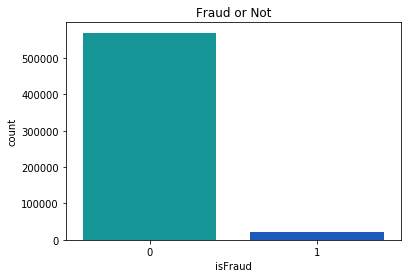

In [20]:
# Distribution of Fraudulent transactions

# Highly imbalanced data

sns.countplot(x=y, palette= 'winter_r')
plt.title('Fraud or Not')
plt.show()

In [17]:
# Finding categorical columns for visualisation
#All column names
all_cols = X.columns

#Numerical columns 
num_cols = X._get_numeric_data().columns

#get categorical cols
cat_cols = list(set(all_cols) - set(num_cols))
cat_cols

['P_emaildomain', 'M1', 'card6', 'M6', 'M2', 'ProductCD', 'card4', 'M3', 'M4']

In [18]:
num_cols

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'dist1',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=402)

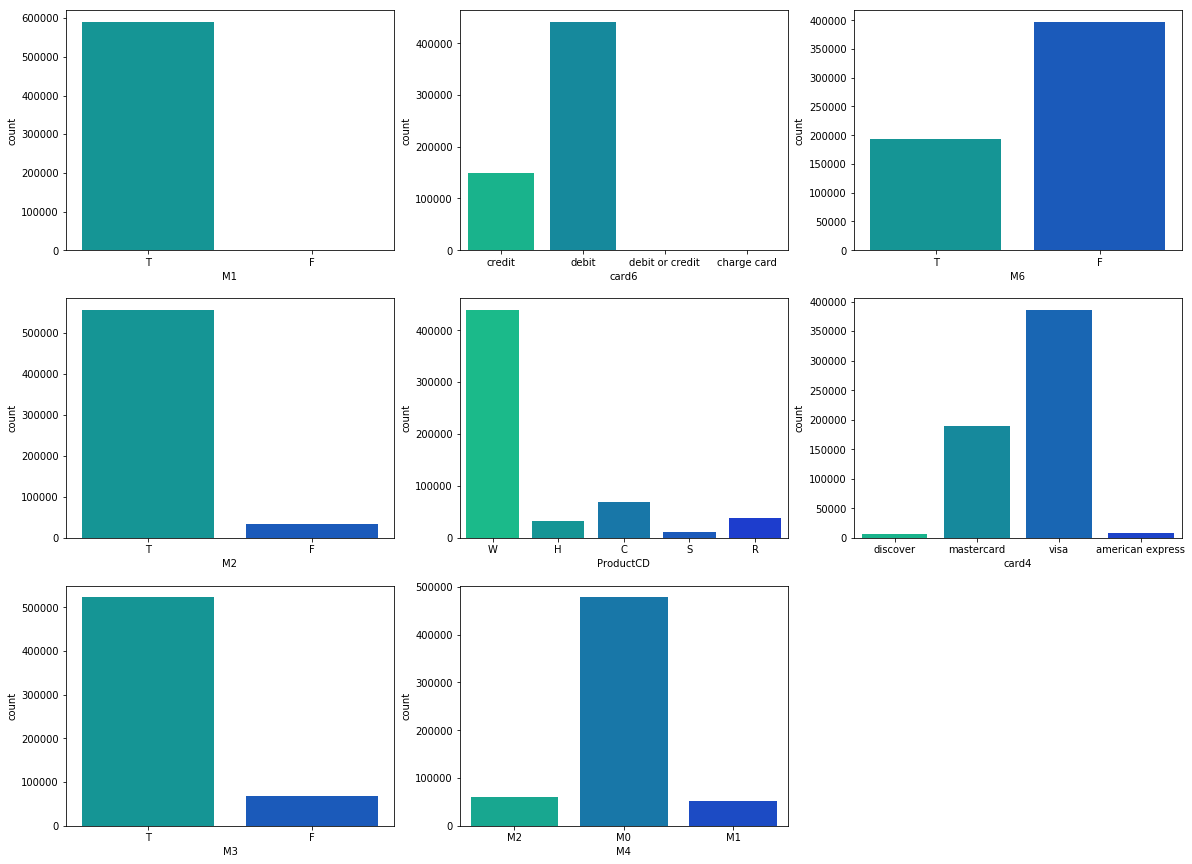

In [19]:
fig = plt.figure(figsize=(20, 15))

j = 1
for i in cat_cols:
    if(i == 'P_emaildomain'):
        continue
    plt.subplot(3, 3, j)
    sns.countplot(x=X[i],  palette='winter_r')
    j = j + 1
    
plt.show()


# Distribution of counts of all categorical variables except P_emaildomain

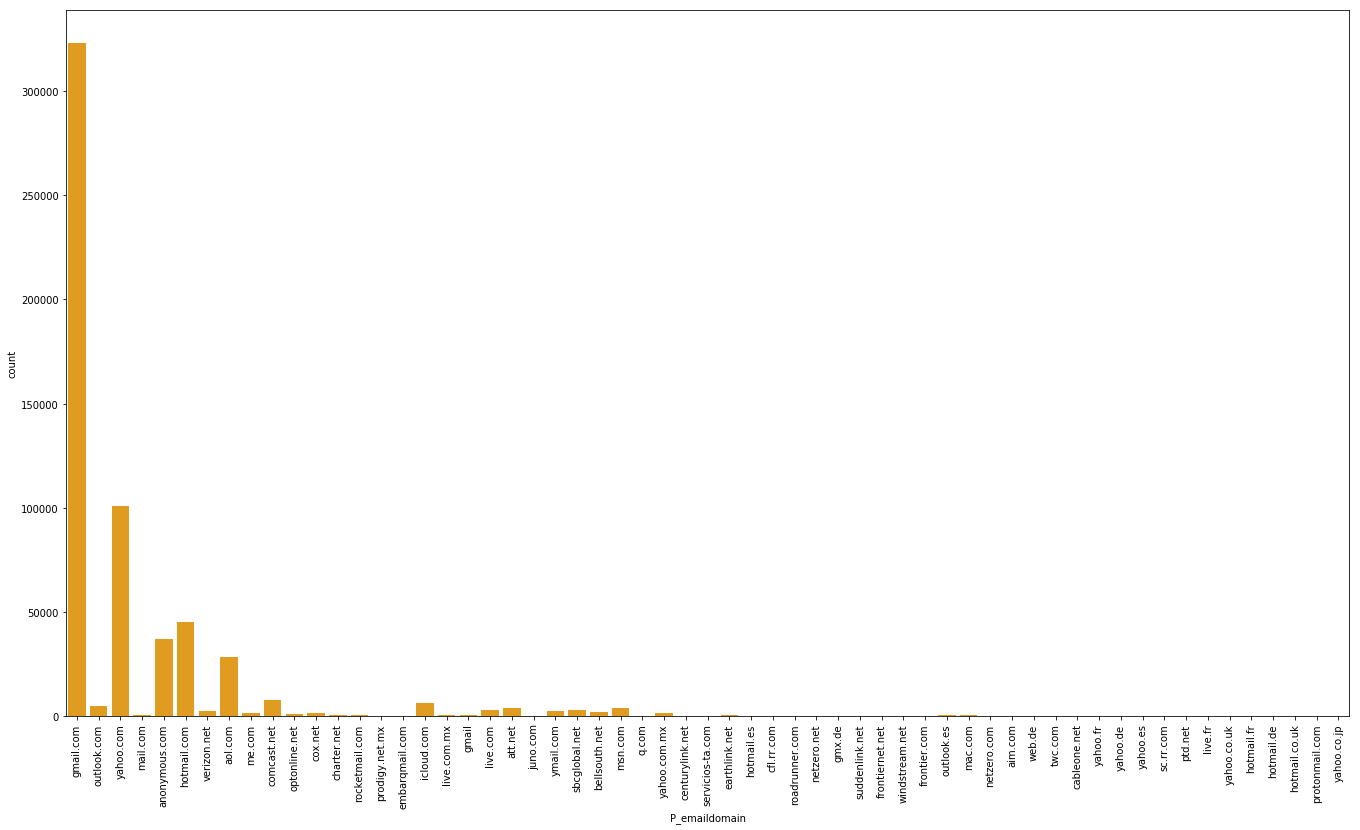

In [20]:
# Distribution of P_emaildomain column
plt.figure(figsize=(23,13))
sns.countplot(x=X['P_emaildomain'], color='orange')
plt.xticks(rotation = 90)
plt.show()

In [21]:
# No need of Id and date column
X = X.drop('TransactionID', axis=1)
test = test.drop('TransactionID', axis=1)

In [22]:
X = X.drop('TransactionDT', axis=1)
test = test.drop('TransactionDT', axis=1)

In [23]:
X.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,68.5,W,13926,99,150,discover,142,credit,315,87,...,99,9,99,99,99,9,10,99,99,255
1,29.0,W,2755,404,150,mastercard,102,credit,325,87,...,99,9,99,99,99,9,10,99,99,255
2,59.0,W,4663,490,150,visa,166,debit,330,87,...,99,9,99,99,99,9,10,99,99,255


In [24]:
# Free up some memory
del train

In [25]:
#Label encode categorical columns

for i in tqdm(cat_cols): 
    label = LabelEncoder()
    label.fit(list(X[i].values)+list(test[i].values))
    X[i] = label.transform(list(X[i].values))
    test[i] = label.transform(list(test[i].values))

100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


In [26]:
X.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,68.5,4,13926,99,150,1,142,1,315,87,...,99,9,99,99,99,9,10,99,99,255
1,29.0,4,2755,404,150,2,102,1,325,87,...,99,9,99,99,99,9,10,99,99,255
2,59.0,4,4663,490,150,3,166,2,330,87,...,99,9,99,99,99,9,10,99,99,255


In [27]:
# convert numerical transaction amount into its eqivalent log value, for training the model better 

X['TransactionAmt'] = X['TransactionAmt'].apply(np.log)
test['TransactionAmt'] = test['TransactionAmt'].apply(np.log)

In [28]:
X.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,4.226834,4,13926,99,150,1,142,1,315,87,...,99,9,99,99,99,9,10,99,99,255
1,3.367296,4,2755,404,150,2,102,1,325,87,...,99,9,99,99,99,9,10,99,99,255
2,4.077538,4,4663,490,150,3,166,2,330,87,...,99,9,99,99,99,9,10,99,99,255


In [29]:
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

In [30]:
X.head(3)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,-0.143632,0.54725,0.821695,-1.623673,-0.261707,-2.753251,-1.347774,-1.720853,0.402500,0.360047,...,-0.518818,-0.274684,-0.469042,-0.482425,-0.075404,-0.066805,-0.068577,-0.086188,-0.078962,0.388853
1,-1.044581,0.54725,-1.457558,0.284185,-0.261707,-1.048192,-2.301011,-1.720853,0.490769,0.360047,...,-0.518818,-0.274684,-0.469042,-0.482425,-0.075404,-0.066805,-0.068577,-0.086188,-0.078962,0.388853
2,-0.300121,0.54725,-1.068263,0.822138,-0.261707,0.656866,-0.775832,0.580638,0.534903,0.360047,...,-0.518818,-0.274684,-0.469042,-0.482425,-0.075404,-0.066805,-0.068577,-0.086188,-0.078962,0.388853


In [32]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = []
i = 1
predictions = np.zeros(test.shape[0])
print('5 Fold Stratified Cross Validation')
print('-----------------------------------')
for train_index, test_index in kf.split(X, y):
    print('Fold no. {}'.format(i))
    xtr, ytr = X.loc[train_index], y.loc[train_index]
    xv, yv = X.loc[test_index], y.loc[test_index]
    
    lr = LogisticRegression()
    lr.fit(xtr, ytr)
    score = roc_auc_score(yv, lr.predict(xv))
    ypreds = lr.predict_proba(test)/5
    predictions += ypreds[:,1]
    print('ROC AUC Score : {}'.format(score))
    cv_score.append(score)
    i += 1
    print('-------------------------------------')

5 Fold Stratified Cross Validation
-----------------------------------
Fold no. 1
ROC AUC Score : 0.5745116827393429
-------------------------------------
Fold no. 2
ROC AUC Score : 0.5763526665429295
-------------------------------------
Fold no. 3
ROC AUC Score : 0.5760730773082569
-------------------------------------
Fold no. 4
ROC AUC Score : 0.5730533680493697
-------------------------------------
Fold no. 5
ROC AUC Score : 0.5775964226797754
-------------------------------------


In [33]:
print('Confusion matrix\n',confusion_matrix(yv, lr.predict(xv)))
print('Cv', cv_score,'\nMean cv Score', np.mean(cv_score))

Confusion matrix
 [[113789    186]
 [  3484    648]]
Cv [0.5745116827393429, 0.5763526665429295, 0.5760730773082569, 0.5730533680493697, 0.5775964226797754] 
Mean cv Score 0.5755174434639349


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook
import random

import xgboost as xgb
#import lightgbm as lgb

import os
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

import gc


In [4]:
import lightgbm as lgb

In [5]:
%%time
df_train_tr = pd.read_csv('train_transaction.csv')
df_train_id = pd.read_csv('train_identity.csv')

CPU times: user 17.1 s, sys: 1.77 s, total: 18.9 s
Wall time: 21.5 s


In [6]:
%%time
df_train_tr = reduce_mem_usage(df_train_tr)
df_train_id = reduce_mem_usage(df_train_id)

Memory usage of properties dataframe is : 1775.152359008789  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
dt

dtype after:  uint8
******************************
******************************
Column:  V29
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V30
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V31
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V32
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V33
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V34
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V35
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V36
dtype before:  float64
dtype after:  uint8
******************************
*****

dtype after:  uint8
******************************
******************************
Column:  V99
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V100
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V101
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V102
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V103
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V104
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V105
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V106
dtype before:  float64
dtype after:  uint8
**************************

dtype after:  uint16
******************************
******************************
Column:  V168
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  V169
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V170
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V171
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V172
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V173
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V174
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V175
dtype before:  float64
dtype after:  uint8
**************************

dtype after:  uint8
******************************
******************************
Column:  V238
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V239
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V240
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V241
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V242
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V243
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V244
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V245
dtype before:  float64
dtype after:  uint16
***************************

dtype after:  float32
******************************
******************************
Column:  V309
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V310
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V311
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V312
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V316
dtype before:  float64
dtype after:  float32
**********

In [7]:
%%time
df_test_tr = pd.read_csv('test_transaction.csv')
df_test_id = pd.read_csv('test_identity.csv')

CPU times: user 14.7 s, sys: 1.07 s, total: 15.8 s
Wall time: 19.4 s


In [8]:
%%time
df_test_tr = reduce_mem_usage(df_test_tr)
df_test_id = reduce_mem_usage(df_test_id)

Memory usage of properties dataframe is : 1519.2380752563477  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  addr1
dtype before:  float64
d

dtype after:  uint8
******************************
******************************
Column:  V30
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V31
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V32
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V33
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V34
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V35
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V36
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V37
dtype before:  float64
dtype after:  uint8
******************************
*****

dtype after:  uint8
******************************
******************************
Column:  V100
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V101
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V102
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V103
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V104
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V105
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V106
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V107
dtype before:  float64
dtype after:  uint8
****************************

dtype after:  uint16
******************************
******************************
Column:  V169
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V170
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V171
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V172
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V173
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V174
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V175
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V176
dtype before:  float64
dtype after:  uint8
***************************

dtype after:  uint8
******************************
******************************
Column:  V239
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V240
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V241
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V242
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V243
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V244
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V245
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  V246
dtype before:  float64
dtype after:  uint8
****************************

dtype after:  float32
******************************
******************************
Column:  V310
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V311
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V312
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V313
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V314
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V315
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V316
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  V317
dtype before:  float64
dtype after:  float32
**********

In [9]:
%%time
df_train = pd.merge(df_train_tr, df_train_id, on = 'TransactionID', how = 'left')
df_test = pd.merge(df_test_tr, df_test_id, on = 'TransactionID', how = 'left')

del df_train_id, df_train_tr, df_test_id, df_test_tr
gc.collect()

CPU times: user 3.3 s, sys: 84.2 ms, total: 3.38 s
Wall time: 3.58 s


In [10]:
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.reset_index(inplace=True)

In [11]:
del df_train, df_test
gc.collect()

21

In [12]:
# Categorical columns
cat_cols = [col for col in df.columns if df[col].dtype in ['object']]
df[cat_cols].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,1097231,1092568,1092653,933583,273161,649492,649492,649492,578042,437117,...,148224,276907,143960,149980,277962,277962,277962,277962,277741,233723
unique,5,4,4,60,60,2,2,2,3,2,...,87,172,461,4,2,2,2,2,2,2799
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,...,Windows 10,mobile safari 11.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,800657,719649,824959,435803,118885,649436,588323,518244,357789,240155,...,42170,23655,33742,132185,149464,267353,215149,168980,159568,92710


In [13]:
# Exploring unique items in the cat cols
for col in cat_cols :
    
    print('-' * 50)
    print('# col : ', col)
    #print(df[df.index < 590540]['isFraud'].groupby(df[col]).sum(),df[df.index < 590540]['isFraud'].groupby(df[col]).count())
    print(100*df[df.index < 590540]['isFraud'].groupby(df[col]).sum()/
          df[df.index < 590540]['isFraud'].groupby(df[col]).count()) 


--------------------------------------------------
# col :  ProductCD
ProductCD
C    11.687269
H     4.766231
R     3.782594
S     5.899553
W     2.039939
Name: isFraud, dtype: float64
--------------------------------------------------
# col :  card4
card4
american express    2.869837
discover            7.728161
mastercard          3.433095
visa                3.475610
Name: isFraud, dtype: float64
--------------------------------------------------
# col :  card6
card6
charge card        0.000000
credit             6.678480
debit              2.426251
debit or credit    0.000000
Name: isFraud, dtype: float64
--------------------------------------------------
# col :  P_emaildomain
P_emaildomain
aim.com             12.698413
anonymous.com        2.321747
aol.com              2.181060
att.net              0.743863
bellsouth.net        2.776323
cableone.net         1.886792
centurylink.net      0.000000
cfl.rr.com           0.000000
charter.net          3.063725
comcast.net          3.11

id_31
BLU/Dash                     0.000000
Cherry                       0.000000
Generic/Android             12.280702
Generic/Android 7.0         19.753086
Inco/Minion                  0.000000
LG/K-200                     0.000000
Lanix/Ilium                 66.666667
M4Tel/M4                     0.000000
Microsoft/Windows            0.000000
Mozilla/Firefox            100.000000
Nokia/Lumia                  0.000000
Samsung/SCH                  0.000000
Samsung/SM-G531H             1.923077
Samsung/SM-G532M            11.333333
ZTE/Blade                   22.222222
android                      0.000000
android browser 4.0         15.000000
android webview 4.0         24.210526
aol                          0.000000
chrome                       7.943925
chrome 43.0 for android     26.388889
chrome 46.0 for android     23.188406
chrome 49.0                  5.563282
chrome 49.0 for android     54.716981
chrome 50.0 for android     26.206897
chrome 51.0                  3.571429
chrome

In [14]:
# Slicing Time data

START_DATE = '2019-01-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df['TransactionDT_Weekdays'] = df['Date'].dt.dayofweek
df['TransactionDT_Days'] = df['Date'].dt.day
df['TransactionDT_Hours'] = df['Date'].dt.hour

df.drop(columns='Date', inplace=True)

In [15]:
# Slicing email cols
def change_value_P_emaildomain(x) :
    if x in ['gmail.com', 'icloud.com', 'mail.com' , 'outlook.es', 'protonmail.com'] :
        return x
    else :
        return 'etc'
    
df.loc[:,'P_emaildomain'] = df['P_emaildomain'].apply(lambda x : change_value_P_emaildomain(x))

def change_value_R_emaildomain(x) :
    if x in ['gmail.com', 'icloud.com', 'mail.com', 'netzero.net', 'outlook.com', 'outlook.es', 'protonmail.com'] :
        return x
    else :
        return 'etc'
    
df.loc[:,'R_emaildomain'] = df['R_emaildomain'].apply(lambda x : change_value_R_emaildomain(x))

In [16]:
def change_value_id_30(x) :
    if x in ['Android 4.4.2', 'Android 5.1.1' 'iOS 11.0.1' 'iOS 11.1.0', 'iOS 11.4.0', 'other'] :
        return x
    else :
        return 'etc'

df.loc[:,'id_30'] = df['id_30'].apply(lambda x : change_value_id_30(x))
def change_value_id_31(x) :
    if x in ['Lanix/Ilium', 'Mozilla/Firefox' 'comodo' 'icedragon', 'opera', 'opera generic'] :
        return x
    else :
        return 'etc'

df.loc[:,'id_31'] = df['id_31'].apply(lambda x : change_value_id_31(x))
def change_value_id_33(x) :
    if x in ['1024x552', '1364x768' '1440x759' '1916x901', '1920x975', '2076x1080', '640x360'] :
        return x
    else :
        return 'etc'

df.loc[:,'id_33'] = df['id_33'].apply(lambda x : change_value_id_33(x))
tmp = 100*df[df.index < 590540]['isFraud'].groupby(df['DeviceInfo']).sum()/df[df.index < 590540]['isFraud'].groupby(df['DeviceInfo']).count()

Device_Info = []

for i in tqdm_notebook(range(len(tmp))) :
    if tmp[i] == 100.0 :
        Device_Info.append(tmp.index[i])

def change_value_DeviceInfo(x) :
    if x in Device_Info :
        return x
    else :
        return 'etc'

df.loc[:,'DeviceInfo'] = df['DeviceInfo'].apply(lambda x : change_value_DeviceInfo(x))

In [17]:
df_num = df.select_dtypes(exclude = ['object'])
df_cat = df.select_dtypes(include = ['object'])
del df
gc.collect()

42

In [18]:
# get cat data with pandas
df_cat_one_hot = pd.get_dummies(df_cat)
df_total = pd.concat([df_num, df_cat_one_hot], axis=1)
df_total.shape

(1097231, 543)

In [19]:
# No need of Id column
df_total.drop(columns = ['TransactionID', 'index'], inplace=True)


In [20]:
del df_num, df_cat
gc.collect()

133

In [21]:
# Training and testing sets 

df_train = df_total[df_total.index < 590540]
df_test = df_total[df_total.index >= 590540]

In [22]:
y = pd.DataFrame(df_train['isFraud'])
X = df_train.drop(columns=['isFraud'])
X_test = df_test.drop(columns=['isFraud'])

In [23]:
X.shape, y.shape, X_test.shape

((590540, 540), (590540, 1), (506691, 540))

In [24]:
del df_train, df_test, df_total
gc.collect()


7

In [28]:
index_array = np.arange(len(X))
val_index = index_array[random.sample(range(0,X.shape[0]), X.shape[0]//10)]
train_index = np.delete(index_array[:X.shape[0]], val_index, axis=0)
len(train_index), len(val_index)

(531486, 59054)

In [29]:
X_train, X_val = X.iloc[train_index], X.iloc[val_index]
y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [ ]:
# Fitting model with XGBoost
 
%%time
prediction_test_fold = []

param = {'booster' : 'gbtree',
         'max_depth' : 11,
         'nthread' : -1,
         'num_class' : 1,
         'objective' : 'binary:logistic',
         'silent' : 1,
         'eval_metric' : 'auc',
         'eta' : 0.15,
         'tree_method' : 'gpu_hist',
         'min_child_weight' : 1,
         'colsample_bytree' : 0.9,
         'colsample_bylevel' : 0.9,
         'seed' : 2019}

print("Train Shape :", X_train.shape,
      "Validation Shape :", X_val.shape,
      "Test Shape :", X_test.shape)
    
dtrn = xgb.DMatrix(X_train, label=y_train, feature_names = X.columns)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = X.columns)
dtst = xgb.DMatrix(X_test, feature_names = X.columns)
    
xgb1 = xgb.train(param, dtrn, num_boost_round=10000, evals = [(dtrn, 'train'), (dval, 'eval')],
                 early_stopping_rounds = 500, verbose_eval=200)
                 
prediction_XGB = xgb1.predict(dtst)
prediction_val_XGB = xgb1.predict(xgb.DMatrix(X_val, feature_names = X.columns))

Train Shape : (531486, 540) Validation Shape : (59054, 540) Test Shape : (506691, 540)
[0]	train-auc:0.861154	eval-auc:0.85288
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 500 rounds.
[200]	train-auc:0.998017	eval-auc:0.968572
[400]	train-auc:0.999828	eval-auc:0.970751
[600]	train-auc:0.999998	eval-auc:0.971461
[800]	train-auc:1	eval-auc:0.971554
[1000]	train-auc:1	eval-auc:0.971264
[1200]	train-auc:1	eval-auc:0.971188
Stopping. Best iteration:
[755]	train-auc:1	eval-auc:0.971774

